# Exploration13. CIFAR-10 이미지 생성하기

## STEP 1. 데이터셋 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

In [3]:
print("max_pixel:", train_x.max())
print("min_pixel:", train_x.min())

max_pixel: 255
min_pixel: 0


In [4]:
# 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max_pixel:", train_x.max())
print("min_pixel:", train_x.min())

max_pixel: 1.0
min_pixel: -1.0


데이터 시각화해보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


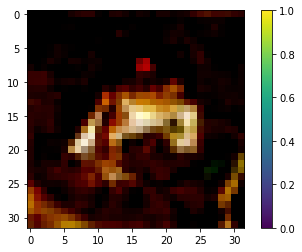

In [5]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

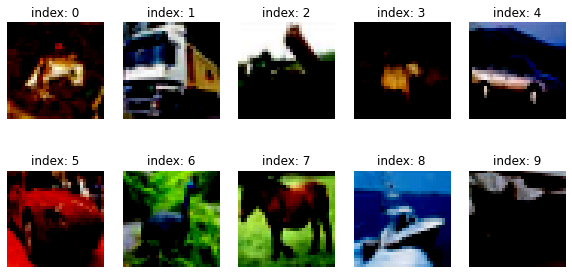

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

미니배치로 잘라주기

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

In [9]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # first: Dense layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Sencond: Reshape layer
    model.add(layers.Reshape((8,8,512)))
    
    # Third: Conv3DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                    activation='tanh'))
    
    return model

마지막 층에서 tanh를 사용하는 이유는 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

generator가 잘 동작하는지 확인해봅니다.

In [11]:
# shape = (1, 100)의 형상을 가지는 랜덤 노이즈 백터 생성
noise = tf.random.normal([1, 100])

첫 번째 1은 batch_size=1, 그리고 (28,28,1)은 사이즈 이미지가 생성되었음을 의미합니다.

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

시각화는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해 (28, 28)shape의 이미지를 꺼낼 수 있도록 만들어 줍니다.

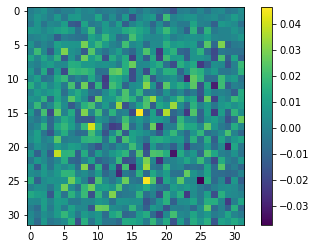

In [13]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

판별자는 가짜 이미지와 진짜 이미지를 입력 받으면 각 이미지 별로 '진짜라고 판단하는 정도' 값을 출력해야 합니다.  
입력은 (28,28,1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다.

In [14]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third. Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth Dense Layer
    model.add(layers.Dense(1))
    
    return model

생성자는 Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 반면 판별자는 Conv2D층으로 이미지의 크기를 점점 줄여나갑니다.  
첫 번째 Conv2D 층에서 입력된 [28, 28, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) -> (16, 16, 64) -> (8, 8, 128)까지 줄어들게 됩니다.  
마지막에는 Flatten층을 사용해 3차원 이미지를 1차원으로 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 백터로 변환합니다.  
1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

생성했던 가짜 이미지를 판별자에 입력시켜 봅니다. 이렇게 나온 값은 아직은 아무런 의미가 없습니다.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00464729]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다. 이는 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래서 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.

각 모델의 목적  
* 생성자: 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
* 판별자: Real Image 판별값, 즉 D(real_image)는 1에, Fake Image판별값, 즉 D(fake_image)는 0에 가까워지는 것  
  
생성자든 구분자든 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 됩니다. 이런 기준을 가지고 각각에 대한 손실함수를 설계합니다.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

판별자 모델에는 값을 정규화시키는 sigmoid나 tanh같은 활성화 함수가 없었습니다. 즉, 구분자가 풀력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있습니다.  
하지만 BinaryCrossEntropy 클래스는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다. 따라서 from_logits를 True로 설정해 줌으로써 내부적으로 0-1 사이의 값으로 정규화를 수행 후 학습을 진행할 수 있게 만들어줍니다.

cross_entropy를 활용해 계산할 Loss들  
* fake_output: 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(Fake_image)
* real_output: 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)  
      
fake_output과 real_output을 0-1에 비교할 때는 tf.ones_like()와 tf.zeros_like() 함수를 활용합니다.

### genarator_loss
generator_loss는 fake_output이 1에 가까워지기를 바라므로, tf.ones_like와의 교차 엔트로피 값을 계산하면 됩니다.  
이 값은 fake_output이 Real Image를 의미하는 1에 가까울수록 작은 값을 가집니다.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
discriminator_loss는 real_output값은 1에 가까워지고 fake_output 값은 0에 가까워지기를 바라므로 두 가지 loss 값을 모두 계산합니다.  
최종 discriminator_loss 값은 이 둘을 더한 것입니다.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy

판별자의 accuracy를 따로 계산해 보는 것은 GAN의 학습에서 매우 중요합니다.  
초반에는 이 값이 1.0에 가깝게 나오다가 서서히 낮아서 둘 다 0,5에 가까워지는 것이 이상적입니다.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

함수 안에서 사용된 함수들의 역할  ex). real_output=tf.Tensor(0.2, 0.4, 0.7, 0.9)
* (1) tf.math.greater_equal(real_output, tf.constant(0.5) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
* (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
* (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

최적화 함수는 Adam을 사용합니다. 학습 품질을 올려보고 싶다면 값을 바꾸어 가며 학습을 진행하는 것이 좋습니다.  
생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어 주어야 합니다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

샘플은 한 번에 16장을 생성하며 매 번 같은 노이즈로 생성해서 진전 과정을 확인할 수 있으므로 고정된 ssed 노이즈를 만들어 두어야 합니다.

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기
하나의 미니배치 당 진행할 train_step 함수를 먼저 만들어야 합니다.  
이 때 데코레이터를 이용하는데, Tensorflow Tutorial에서는 데코레이터의 역할을 다음과 같이 정의하고 있습니다.
* tf.function : Compiles a function into a callable TensorFlow graph

@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다. 

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train step 함수의 단계들
* (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
* (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
* (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
* (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
* (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : fake_output, real_output으로 discriminator가
* (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

train_step과 일정 간격으로 학습 현황을 볼 수 있는 함수를 만듭니다.  
고정된 ssed를 이용하므로 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))

    plt.show()

이 함수는 plt에 저장되어 보여지는 이미지를 plt.savefig로 간단히 파일화 해서 저장합니다.  

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.  
checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다.  
checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용합니다.

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 600

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

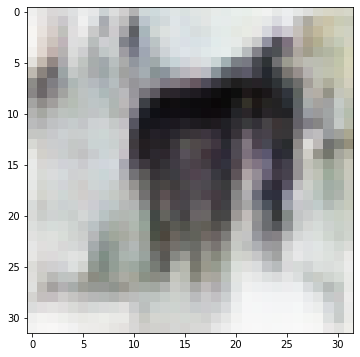

In [42]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

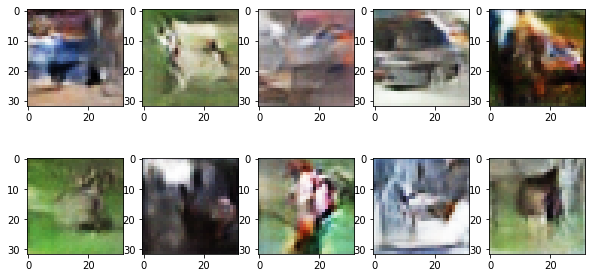

In [45]:
plt.figure(figsize=(10 ,5))

for i in range(10):
    plt.subplot(2, 5, i+1)

    generator = checkpoint.generator
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.